# Classificação de conteúdo seguro para menores em redes sociais.

Dado o inegável fato das crianças e adolescentes constituírem parte significante do percentual de usuários de redes sociais, é importante trabalhar na redução de danos dos impactos negativos que podem ser causados devido essa exposição. Nos últimos tempos, e com o surgimento da série adolescência, vem-se debatendo como as redes sociais estão se tornando mecanismos de aliciamento de menores para ideologias radicalistas.

Para isso, a proposta deste trabalho é construir um classificador que visa segmentar conteúdos seguros para menores de idade, seguindo as principais [diretrizes do guia de telas do governo federal](https://www.gov.br/secom/pt-br/assuntos/uso-de-telas-por-criancas-e-adolescentes/guia/guia-de-telas_sobre-usos-de-dispositivos-digitais_versaoweb.pdf) e fundação ABRINQ.

Os dados recolhidos vieram de um [repositório](https://github.com/GedorN/dataset_comentarios_toxicos) no github, que capturou textos na internet, incluindo de redes sociais como twitter, com rotulagem referente à toxicidade do conteúdo. Portanto, não contendo exatamente o rótulo almejado pelo problema atacado aqui.

Desta forma, estamos trabalhando com um problema de classificação em que os dados não estão rotulados, sendo assim necessária uma pipeline de supervisão fraca.


In [1]:
import pandas as pd
import copy
import random
import time
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from plotly.subplots import make_subplots
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, cohen_kappa_score, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier


In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd drive/MyDrive

Mounted at /content/drive


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/GedorN/dataset_comentarios_toxicos/refs/heads/main/comentarios_toxicos_ptBR.csv').drop(columns='Unnamed: 0', axis=1)

## O dataset

O dataset escolhido é de tweets brasileiros, com rotulagem voltada para conteúdo tóxico. A proposta deste projeto é montar um dataset com rótulos semelhantes, se o conteúdo é ou não seguro para menores. A ideia inicial é aproveitar estes rótulos, tendo em mente que conteúdos tóxicos por si só não são seguros para menores

In [4]:
print(f'O dataset contém {data.shape[0]} linhas')

O dataset contém 29922 linhas


O dataset trouxe o texto normalizado e o texto raw

In [5]:
data.sample(100)

,text,text_norm,toxic
11968,>>28986>the ane lineage is defined by associat...,the acne dota are define by association with m...,1
13469,rt @user gaúcho veio com fome 🔞🔥de ppk🐸💧💧\nmat...,gaúcho veio fome piroca matei vontade ...,1
21573,que nojo desse homem escroto do caralho pqp,nojo desse homem escroto caralho puta pariu,1
3104,Até quando esses homens e mulheres irão atrapa...,homens mulheres irão atrapalhar país acertarão...,0
18318,pau no cu desse asiatico filho da puta,pau cu desse asiático filho puta,0
...,...,...,...
22177,rt @user t谩 na hora do bolsonaro recompensar o...,hora bolsonaro recompensar apoio entusiasmado ...,0
11282,Acabei de passar na frente de uma borracharia ...,acabei passar frente borracharia cheia gente g...,1
29714,sempre que vou postar uma foto acontece isso,sempre vou postar foto acontece,0
24355,"queria tanto ficar de casa dormindo, mas a obr...",queria tanto ficar casa dormindo obrigação chama,0


Entendendo os textos rotulados como tóxicos

In [ ]:
data[data['toxic'] == 1].sample(100)

,text,text_norm,toxic
27445,"caramba, não achei que ia viver pra ver o quej...",caralho achei ia viver pra ver queima minas at...,1
25825,">>57402anão, se você não broxa quando se mastu...",2anão broxa masturba provavelmente problema ps...,1
3577,a argentina tem uma das histórias mais frustra...,argentina histórias frustrantes mundo canadá l...,1
988,"e um broxa, filho da puta ..",broxa filho puta,1
3519,uma sapatão feliz com seu look e seu corpo não...,sapatão feliz look corpo quer guerra ninguém,1
...,...,...,...
28874,@user kkkkkkk porra eu queria tanto viver esse...,porra queria tanto viver meme,1
29906,estou no primeiro dia… caralho como é difícil ...,primeiro dia … caralho difícil porra preciso p...,1
15894,to de boa cabuloso dessa bixa,to boa sinistro dessa bixa,1
18656,">>41848obrigado, anão. o máximo que aguentei f...",8obrigado anão máximo aguentei dias perdi form...,1


### Refazendo pré processamento

Acredito que a coluna text_norm retirou muitos termos que ajudavam a dar sentido às frases. Para facilitar na etapa das label functions baseadas em heurísticas vou fazer de uma forma diferente.

Nas celulas abaixo, vou fazer o pré processamento dos textos de modo que o texto processado guarde o máximo possível de sentido.

In [6]:
import re
import unicodedata

def normalize_repetitions(word):
    # reduz repetições exageradas: "boooom" → "boom"
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def clean_tweet(text):
    # 1. Substituir todas menções por token temporário
    text = re.sub(r'@[\w_]+', '', text)

    # 3. Remover URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # 4. Remover Retweets (prefixo 'rt')
    text = re.sub(r'\brt\b', '', text)

    # 5. Remover números
    text = re.sub(r'\d+', '', text)

    # 6. Normalizar acentos
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

    # 7. Remover caracteres especiais
    text = re.sub(r'[^\w\s!?.,]', '', text)

    # 8. Corrigir repetições exageradas
    text = ' '.join([normalize_repetitions(word) for word in text.split()])

    # 9. Espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    return text.lower()


In [136]:
data['text'] = data['text'].astype(str)

data['custom_norm'] = data['text'].apply(clean_tweet)
data = data[['text', 'text_norm', 'custom_norm', 'toxic']] #reorganizando colunas

In [137]:
data.sample(50)

,text,text_norm,custom_norm,toxic
18242,"tnc, esse mês já começa mal. azar do crl",tnc mês começa mal azar caralho,"tnc, esse mes ja comeca mal. azar do crl",1
4465,aproveitando o gancho desses dois posts:>>6037...,aproveitando gancho desses dois posts 2como mo...,aproveitando o gancho desses dois postscomo se...,1
23190,"Nos últimos treinos, Alberto Valentim manteve ...",últimos treinos alberto valentim manteve golei...,"nos ultimos treinos, alberto valentim manteve ...",0
10047,caralho to rachando do vídeo de ontem kkkkkkk,caralho to rachando vídeo ontem,caralho to rachando do video de ontem kk,1
6356,Joga muito,joga,joga muito,0
20602,"rt @user vontade de abrir a alma é grande, mas...",vontade abrir alma grande medo tomar cu maior,"vontade de abrir a alma e grande, mas o medo d...",1
19713,@user Lamentável. Finalmente uma voz dentro do...,lamentável finalmente voz dentro governo ousou...,lamentavel. finalmente uma voz dentro do gover...,0
9169,cheirinho de brigadeiro que delícia! 😙😋\n \n ...,cheirinho brigadeiro delícia,cheirinho de brigadeiro que delicia! sextaliga...,0
20143,"comecei dia 15, mas estou sem me masturbar há ...",comecei dia masturbar semana sei dia exato vou...,"comecei dia , mas estou sem me masturbar ha ma...",1
25716,"“a mana é macaca veia já” \n\ndeves, nataly",“ mana macaca veia ” deves natal,"a mana e macaca veia ja deves, nataly",0


### Sampling e rotulagem
Como os rotulos desse dataset contém muito ruído (conteúdos não tóxicos rotulados com tal) e a proposta do projeto engloba mais do que apenas conteúdo tóxico, vou optar por fazer manualmente a rotulagem desses dados, segue abaixo o cálculo feito para determinar a amostragem utilizada para os conjunto de desenvolvimento e teste.

A rotulagem foi feita pelo Label Studio,

In [11]:
import math

n = len(data)  # número de tweets

z = 1.96  # 95% de confiança

# Proporção esperada de tweets não toxicos
# Assumindo 50% pensando no pior caso e maximizando n de amostras
p = 0.5

e = 0.05  # Margem de erro aceitável

#formula para calcular tamanho da amostra
sample_size = math.ceil((z**2 * p * (1 - p)) / e**2)

print(f"Sample size: {sample_size}")

Sample size: 385


In [139]:
#arredondando para 400 amostras para cada set

# embaralhar o dataset
df = data.sample(frac=1.0, random_state=42)

#quantidade de amostras
desired_sample_size = 400

#dividindo dataset em treino e dev/test
df_dev_test = df[: desired_sample_size * 2]

# The remaining samples are used for the training set
df_train = df[desired_sample_size * 2 :]

In [140]:
df_train = df_train.drop(columns=["text", "text_norm", "toxic"], axis=1)
df_dev_test = df_dev_test.drop(columns=["text", "text_norm", "toxic"], axis=1)

In [141]:
df_dev_test_path = 'Estudos/Weak_Supervision/NSFM_Project/data/dev_test.csv'
df_train_path = 'Estudos/Weak_Supervision/NSFM_Project/data/train.csv'
df_dev_test.to_csv(df_dev_test_path)
df_train.to_csv(df_train_path)

## Determinando LFs

Utilizarei os próprios rótulos do dataset como uma LF, como dito anteriormente, juntamente de um modelo do huggingface [FredZhang7/one-for-all-toxicity-v3](https://huggingface.co/FredZhang7/one-for-all-toxicity-v3) que funciona tanto para português quanto espanhol. Nas minhas LFs baseadas em heurísticas focarei principalmente em demarcação de conteúdo sexual. Além disso, vou tentar utilizar o [brescia/sexual_harrasment_content](https://huggingface.co/brescia/sexual_harrasment_content) para ajudar nesta tarefa. Ele é apenas para o inglês, mas vou adicionar uma etapa de tradução na LF.


In [7]:
#Padronizando retorno das lf
POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

### One for all toxicity

In [8]:
#importando tokenizador e modelo
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("FredZhang7/one-for-all-toxicity-v3")
model = AutoModelForSequenceClassification.from_pretrained("FredZhang7/one-for-all-toxicity-v3").to(device)

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

c:\Users\cat13\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cat13\.cache\huggingface\hub\models--FredZhang7--one-for-all-toxicity-v3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [9]:
from snorkel.preprocess import preprocessor
from snorkel.labeling import labeling_function


@preprocessor(memoize=True)
def is_toxic(text):
  encoding = tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=208,
      padding="max_length",
      truncation=True,
      return_tensors="pt"
  )

  input_ids = encoding["input_ids"].to(device)
  attention_mask = encoding["attention_mask"].to(device)

  with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1)

  return int(predicted_labels[0]) #1 -> toxico; 0 -> não tóxico



@labeling_function()
def lf_toxic_model(x):
    return is_toxic(x.text)


Observando comportamento do classificador nos dados nos dados

In [ ]:
sample_100 = df_train.sample(100)

In [ ]:
sample_100['toxicity_clf'] = sample_100['custom_norm'].apply(is_toxic)

In [ ]:
sample_100.head(25)

,custom_norm,toxicity_clf
695,meta de vida isso sim e marola o resto e so co...,0
29167,"eu ja passei por tudo isso, anao, ja fiz e viv...",0
980,"user_ref esquizo nao mo, pfv chama de saco de ...",0
24293,user_ref exato. a oposicao nao percebe que nao...,0
7782,ta tarde pra virar tricolor ?? br ta visado pr...,0
21063,to vendo gente decepcionada pelo comentario e ...,0
25222,dizer que o final do capitao america foi ridic...,0
18068,"por que e quase sempre um cara zoado, cafona p...",0
19152,"isso e pela cueca estar frouxa, nao estava de ...",1
9974,silvio que grande asneira seu asno,1


In [ ]:
#apenas rotulados como tóxico

sample_100[sample_100['toxicity_clf'] == 1].head(25)

,custom_norm,toxicity_clf
19152,"isso e pela cueca estar frouxa, nao estava de ...",1
9974,silvio que grande asneira seu asno,1
28828,user_ref roludo falando e metendo a pica,1
11237,"me desculpe se sou doente as vezes, mas e q o ...",1
5601,na cabeca dos retardados proaborto os problema...,1
11423,"essa forma nojenta de falarnem sou o quotado, ...",1
23454,user_ref todo mundo que ta falando mal da beyo...,1
9416,user_ref sco pa tu mana eh minha rola vai toma...,1
7128,ai gente nao respondendo do jeito q eu planeje...,1
26931,caralho quem consegue escutar atitude ?? que b...,1


In [ ]:
#apenas rotulados como não tóxico

sample_100[sample_100['toxicity_clf'] == 0].head(25)

,custom_norm,toxicity_clf
695,meta de vida isso sim e marola o resto e so co...,0
29167,"eu ja passei por tudo isso, anao, ja fiz e viv...",0
980,"user_ref esquizo nao mo, pfv chama de saco de ...",0
24293,user_ref exato. a oposicao nao percebe que nao...,0
7782,ta tarde pra virar tricolor ?? br ta visado pr...,0
21063,to vendo gente decepcionada pelo comentario e ...,0
25222,dizer que o final do capitao america foi ridic...,0
18068,"por que e quase sempre um cara zoado, cafona p...",0
10824,user_ref que dia lindo vsf,0
14527,"user_ref simm, nessa hora que eu mando a merda",0


É notável que o classificador obteve um bom desempenho em textos com mensagens de ódio, no entanto, como esperado, não filtra muito bem mensagens com teor sexual.

O próximo passo agora seria utilizar um modelo do huggingface para fazer a detecção de conteúdo sexual, mas não existe nenhum em português ou idioma próximo. Pensei em traduzir os textos, mas devido a quantidade de textos e caracteres, terminou que a tarefa seria bastante custosa. Extraploraria bastante o limite gratuito de 500.000 caracteres (no conjunto de treino há cerca de 4 milhões) da API do google tradutor.

Procurei alguns modelos do hugging face para fazer a tradução mas o resultado foi desastroso

O melhor a se fazer aqui é seguir com a criação de label functions que foquem em detecção de conteúdo sexual e aplicar uma pipeline de aprendizado semi supervisionado para gerar uma LF que detecta conteúdo tóxico e sexual

### Pipeline de aprendizado semi supervisionado

Importando conjunto de desenvolvimento/teste rotulado e dividindo corretamente os arquivos


In [ ]:
from sklearn.model_selection import train_test_split


def convert_sentiment(sentiment):
    return 1 if sentiment=='Não' else 0


df = pd.read_csv('Estudos/Weak_Supervision/NSFM_Project/data/dev_test_labeled.csv')
df = df[['custom_norm', 'sentiment']] #filtrando colunas do label studio

df.loc[:, 'nsfm'] = df['sentiment'].apply(convert_sentiment) #ajustando labels
df = df.drop_duplicates().drop(columns='sentiment')


dev_df, test_df = train_test_split( df, test_size=0.5, stratify=df['nsfm'], random_state=42 )

dev_df = dev_df.rename(columns={'custom_norm': 'text'})
test_df = test_df.rename(columns={'custom_norm': 'text'})


dev_df.to_csv('Estudos/Weak_Supervision/NSFM_Project/data/dev_df.csv')
test_df.to_csv('Estudos/Weak_Supervision/NSFM_Project/data/test_df.csv')

In [29]:
df_train = pd.read_csv('data/train.csv').drop(columns='Unnamed: 0')
dev_df = pd.read_csv('data/dev_df.csv')
ssl_train = df_train.rename(columns={'custom_norm': 'text'}).dropna()

In [33]:
dev_df = dev_df.drop(columns='Unnamed: 0')
dev_df.columns = ['text', 'nsfm']

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Gerando features com TFIDF

tfidf_vec_ssl = TfidfVectorizer(
    ngram_range=(1, 2),
    strip_accents="unicode",
    lowercase=True,
    max_features=500,
    min_df=3,
)

#Ajustando vetorizador no conjunto de treino
tfidf_vec_ssl.fit(ssl_train.text)

#Aplicando transformações no conjunto de desenvolvimento
X_dev = tfidf_vec_ssl.transform(dev_df.text)

# convertendo para array
X_dev = X_dev.toarray()

# labels
y_dev = dev_df.nsfm.values

# Print the shape of the TF-IDF feature matrix
X_dev.shape

(399, 500)

In [ ]:
#helper do prof elias 
from utils.classification import train_and_evaluate_classification_models

In [36]:
df_results, classification_reports, calibration_plots = train_and_evaluate_classification_models(X_dev, y_dev)

Model: Calibrated-LSVC - F1: 0.5990 - Balanced Accuracy: 0.5013 - Accuracy: 0.5990 - Matthews Correlation Coefficient: 0.0074 - Elapsed time: 2.45s
              precision    recall  f1-score   support

           0       0.60      0.97      0.75       241
           1       0.42      0.03      0.06       158

    accuracy                           0.60       399
   macro avg       0.51      0.50      0.40       399
weighted avg       0.53      0.60      0.47       399

[[234   7]
 [153   5]]
******************** 

Model: Logistic Regression - F1: 0.6015 - Balanced Accuracy: 0.5906 - Accuracy: 0.6015 - Matthews Correlation Coefficient: 0.1790 - Elapsed time: 0.62s
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       241
           1       0.50      0.54      0.52       158

    accuracy                           0.60       399
   macro avg       0.59      0.59      0.59       399
weighted avg       0.61      0.60      0.60       399



Apesar dos resultados não serem muito bons, cumpre o requisito de 50% de acurácia para uma LF

In [129]:
df_results.sort_values(by='F1', ascending=False)

,Model,F1,Balanced Accuracy,Accuracy,Matthews Correlation Coefficient,Elapsed Time,Confusion Matrix,Classification Report
2,Random Forest,0.629073,0.569791,0.629073,0.170501,10.306442,[[206 35]\n [113 45]],precision recall f1-score ...
5,Naive Bayes,0.624060,0.549294,0.624060,0.143216,3.795432,[[219 22]\n [128 30]],precision recall f1-score ...
8,Extra Trees,0.601504,0.573126,0.601504,0.150123,6.268751,[[171 70]\n [ 89 69]],precision recall f1-score ...
1,Logistic Regression,0.601504,0.590564,0.601504,0.179002,0.675368,[[155 86]\n [ 73 85]],precision recall f1-score ...
0,Calibrated-LSVC,0.598997,0.501300,0.598997,0.007445,5.506398,[[234 7]\n [153 5]],precision recall f1-score ...
6,K-Nearest Neighbors,0.598997,0.502390,0.598997,0.012704,0.576470,[[233 8]\n [152 6]],precision recall f1-score ...
3,XGBoost,0.578947,0.539196,0.578947,0.083602,4.652359,[[176 65]\n [103 55]],precision recall f1-score ...
7,Decision Tree,0.561404,0.538841,0.561404,0.078135,0.910461,[[156 85]\n [ 90 68]],precision recall f1-score ...
4,SGD,0.553885,0.533707,0.553885,0.067414,0.331299,[[152 89]\n [ 89 69]],precision recall f1-score ...


In [37]:
calibration_plots

#### Construindo lf com base no classificador

In [38]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np

model_ssl = SelfTrainingClassifier(MultinomialNB())

# Transformar os dados
X_unlabeled = tfidf_vec_ssl.transform(ssl_train.text).toarray()
y_unlabeled = np.array([-1] * len(ssl_train))

X_labeled = tfidf_vec_ssl.transform(dev_df.text).toarray()
y_labeled = dev_df.nsfm.values

# Treinar o modelo com dados rotulados e não rotulados
model_ssl.fit(X=np.vstack([X_labeled, X_unlabeled]), y=np.concatenate([y_labeled, y_unlabeled]))


SelfTrainingClassifier(base_estimator=MultinomialNB())

In [39]:
from snorkel.preprocess import preprocessor

@preprocessor(memoize=True)
def semi_superv_classifier(x):

    vectorized_text = tfidf_vec_ssl.transform([x.text])

    pred_proba = model_ssl.predict_proba(vectorized_text)

    pred = np.argmax(pred_proba, axis=1)

    x.label_pred_ssl = POSITIVE if pred == 1 else NEGATIVE

    x.score_ssl = pred_proba[0][pred]

    return x

In [40]:
from snorkel.labeling import labeling_function

@labeling_function(pre=[semi_superv_classifier])
def lf_ssl(x):

    if x.score_ssl >= 0.90:

        if x.label_pred_ssl == 1:
            return POSITIVE

        elif x.label_pred_ssl == 0:
            return NEGATIVE
    else:
        return ABSTAIN

### LF baseadas em heurísticas

In [42]:
def load_terms(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        return set(line.strip().lower() for line in f if line.strip())


# Carregar arquivos
EXPLICIT_KEYWORDS_path =  'data/sex_keywords.txt'
EUPHEMISMS_path = 'data/sex_euphemisms.txt'
EXPLICIT_BODYPARTS_path = 'data/sex_bodyparts.txt'
SEXUAL_CONTENT_path = 'data/sex_content.txt'

EXPLICIT_KEYWORDS = load_terms(EXPLICIT_KEYWORDS_path)
EUPHEMISMS = load_terms(EUPHEMISMS_path)
EXPLICIT_BODYPARTS = load_terms(EXPLICIT_BODYPARTS_path)
SEXUAL_CONTENT = load_terms(SEXUAL_CONTENT_path)



In [43]:
def explicit_keywords(x):
    return POSITIVE if any(word in x.lower() for word in EXPLICIT_KEYWORDS) else ABSTAIN

def euphemisms(x):
    return POSITIVE if any(phrase in x.lower() for phrase in EUPHEMISMS) else ABSTAIN

def explicit_bodypart(x):
    return POSITIVE if any(phrase in x.lower() for phrase in EXPLICIT_BODYPARTS) else ABSTAIN

def sexual_content(x):
    return POSITIVE if any(phrase in x.lower() for phrase in SEXUAL_CONTENT) else ABSTAIN

In [44]:
from snorkel.labeling import labeling_function

@labeling_function()
def lf_explicit_keywords(x):
    return explicit_keywords(x.text)

@labeling_function()
def lf_euphemisms(x):
    return euphemisms(x.text)

@labeling_function()
def lf_explicit_bodypart(x):
    return explicit_bodypart(x.text)

@labeling_function()
def lf_sexual_content(x):
    return sexual_content(x.text)

In [45]:
train_sample = df_train.sample(100)

# Aplicar LFs
train_sample["explicit_keywords"] = train_sample["custom_norm"].apply(explicit_keywords)
train_sample["euphemisms"] = train_sample["custom_norm"].apply(euphemisms)
train_sample["sexual_content"] = train_sample["custom_norm"].apply(sexual_content)
train_sample["explicit_bodypart"] = train_sample["custom_norm"].apply(explicit_bodypart)


In [47]:
train_sample.head(25)

,custom_norm,explicit_keywords,euphemisms,sexual_content,explicit_bodypart
19862,sorteio k regras e fav o tweet esteja seguindo...,-1,-1,-1,-1
369,"this.perdi.anoes sao arrogantes demais, ningue...",-1,-1,-1,-1
9945,bando de biscoitero do caralho,-1,-1,-1,-1
23897,"eu nao te chamei de gorda, e foi sem querer po",-1,-1,-1,-1
19018,"retrata nas ilustracoes a doenca mental, faz u...",-1,-1,-1,-1
28265,observando cada detalhe e ficando em silencio.,-1,-1,-1,-1
17905,so role saudavel,-1,-1,-1,-1
21308,eu posso ate ser feia mas eu ja fui mais feia,-1,-1,-1,-1
9946,"nao e possivel que voces achem isso normal, se...",-1,-1,-1,-1
27715,"legal bm hj q eu to sozinha no museu ,resolve ...",-1,-1,-1,-1


## Aplicando e analisando LFs

In [48]:
lfs = [lf_toxic_model, lf_ssl, lf_explicit_keywords, lf_euphemisms, lf_explicit_bodypart, lf_sexual_content]

In [49]:
from snorkel.labeling import PandasLFApplier
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=ssl_train)


100%|██████████| 29115/29115 [3:20:54<00:00,  2.42it/s]      


In [50]:
import snorkel
import pandas as pd
from snorkel.labeling import (
    LFAnalysis,
    PandasLFApplier,
    filter_unlabeled_dataframe,
    labeling_function,
)
from snorkel.labeling.model.label_model import LabelModel
from snorkel.utils import probs_to_preds



LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_toxic_model,0,"[0, 1]",1.000000,0.991997,0.271132
lf_ssl,1,[0],0.981315,0.981315,0.265671
lf_explicit_keywords,2,[1],0.134123,0.134123,0.128937
lf_euphemisms,3,[1],0.004225,0.004225,0.004190
lf_explicit_bodypart,4,[1],0.060690,0.060690,0.059900
lf_sexual_content,5,[1],0.006079,0.006079,0.006045


In [51]:
LFAnalysis(L=L_train, lfs=lfs).label_coverage()


1.0

In [52]:
L_dev = applier.apply(df=dev_df)

100%|██████████| 399/399 [04:22<00:00,  1.52it/s]


As lf que mais contribuíram foram a do modelo de detecção de conteúdo tóxico e a do aprendizado semi supervisionado. Apesar das métricas do modelo de ssl não serem muitos boas, ele ficou com uma acurácia bem próxima do modelo do hugginface, que em sua página apresentava métricas bem superiores. As outras obtiveram uma cobertura muito baixa, no entanto algumas com uma boa acurácia

In [54]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=dev_df.nsfm.values)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_toxic_model,0,"[0, 1]",1.000000,0.989975,0.260652,268,131,0.671679
lf_ssl,1,[0],0.977444,0.977444,0.258145,239,151,0.612821
lf_explicit_keywords,2,[1],0.130326,0.130326,0.120301,40,12,0.769231
lf_euphemisms,3,[1],0.005013,0.005013,0.005013,1,1,0.500000
lf_explicit_bodypart,4,[1],0.057644,0.057644,0.055138,15,8,0.652174
lf_sexual_content,5,[1],0.002506,0.002506,0.000000,1,0,1.000000


## Label Model

Para decidir o rótulo utilizei majority vote, no entanto levando em consideração a cobertura das minhas LF, a maioria das amostras vai estar com rótulo sendo disputado entre a lf_toxic_model e lf_ssl. O ideal seria conseguir outras lf com maior cobertura. Na prática o que está sendo feito, para maioria, é sortear entre o rótulo do toxic_model e do modelo de ssl

In [ ]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train_majority_vote = majority_model.predict(L=L_train, tie_break_policy="random")  # Usando majority vote
preds_train_majority_vote

array([0, 0, 0, ..., 0, 0, 1])

In [60]:
labels = pd.Series(preds_train_majority_vote)

train_dist = labels.value_counts(normalize=True).sort_index()
train_dist

0    0.862339
1    0.137661
Name: proportion, dtype: float64

In [61]:
dev_dist = dev_df.nsfm.value_counts(normalize=True).sort_index()
dev_dist

nsfm
0    0.60401
1    0.39599
Name: proportion, dtype: float64

No conjunto de validação obtivemos uma distribuição um pouco diferente dos rótulos, mas que mesmo assim não desvia muito da natureza dos dados. A proporção de conteúdo seguro é bem maior que a de conteúdo não seguro para menores.

Levando em consideração o desbalanceamento dessas classes, vale ressaltar que utilizar acurácia na LF Analysis não foi uma boa ideia

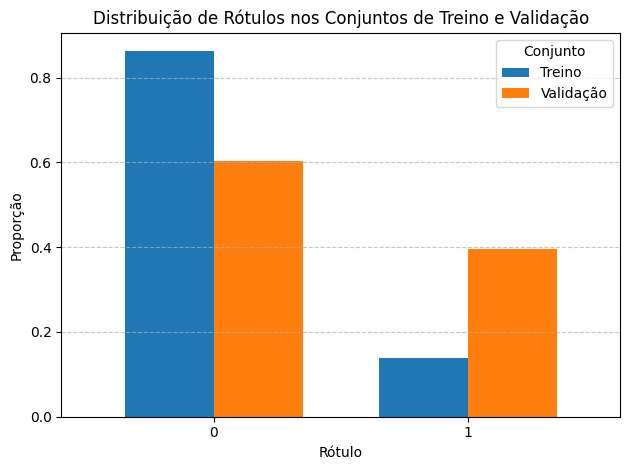

In [63]:
import matplotlib.pyplot as plt
df_plot = pd.DataFrame({
    'Treino': train_dist,
    'Validação': dev_dist
})

# Plotando gráfico de colunas clusterizado
df_plot.plot(kind='bar', width=0.7)
plt.title('Distribuição de Rótulos nos Conjuntos de Treino e Validação')
plt.xlabel('Rótulo')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Conjunto')
plt.tight_layout()
plt.show()

In [80]:
from snorkel.labeling.model import LabelModel

#distribuicao das classes do conjunto de desenvolvimento 
class_balance = np.bincount(y_dev) / len(y_dev)

#label model inicializado com cardinalidade binária
label_model = LabelModel(cardinality=2, verbose=True)

#treinando label model utilizadno as lf como features
label_model.fit(L_train=L_train, n_epochs=300, log_freq=50, seed=271828, class_balance=class_balance)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/300 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.501]
INFO:root:[50 epochs]: TRAIN:[loss=0.015]
 24%|██▍       | 72/300 [00:00<00:00, 711.04epoch/s]INFO:root:[100 epochs]: TRAIN:[loss=0.007]
INFO:root:[150 epochs]: TRAIN:[loss=0.005]
100%|██████████| 300/300 [00:00<00:00, 733.97epoch/s]
INFO:root:Finished Training


As métricas do label model são um pouco inferiores às das label functions. É interessante que para a classe 0 ele conseguiu aumentar todas as métricas, o que aparenta ser mais difícil de generalizar é de fato a classe 1, que por sua vez tem precisão e f1 aceitáveis, porém um recall baixo. Isso indica que o modelo possui uma boa confiança quando determina que o texto é nsfm, no entanto deixa de rotular corretamente vários outros textos nsfw.

In [ ]:
from sklearn.metrics import classification_report

#usando majority vote no conjunto de desenvolvimento 
majority_pred = majority_model.predict(L=L_dev)

#fazendo predições no conjunto de dev utilizadno o label model
snorkel_label_model_pred = label_model.predict(L=L_dev)


print(f"Classification report for majority model: \n{classification_report(dev_df.nsfm.values, majority_pred)}")

#abstenções majority vote
print(f"Number of abstains: {np.count_nonzero(majority_pred == -1)}")

#espaço entre os reports
print("\n\n")

print(f"Classification report for label model: \n{classification_report(dev_df.nsfm.values, snorkel_label_model_pred)}")

#abstenções label model
print(f"Number of abstains: {np.count_nonzero(snorkel_label_model_pred == -1)}")

Classification report for majority model: 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.68      0.89      0.77       241
           1       0.86      0.11      0.20       158

    accuracy                           0.58       399
   macro avg       0.51      0.33      0.32       399
weighted avg       0.75      0.58      0.54       399

Number of abstains: 61



Classification report for label model: 
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       241
           1       0.68      0.46      0.55       158

    accuracy                           0.70       399
   macro avg       0.69      0.66      0.66       399
weighted avg       0.70      0.70      0.69       399

Number of abstains: 0


c:\Users\cat13\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\cat13\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\cat13\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [83]:
# gerando prediçoes contínuas das classes no conjunto de treino
probs_train_snorkel = label_model.predict_proba(L=L_train)
probs_train_majority_vote = majority_model.predict_proba(L=L_train)

labels_train_snorkel = label_model.predict(L=L_train)
labels_train_majority_vote = majority_model.predict(L=L_train)

In [ ]:
# distribuição agora mais parecida com a do conjutno de desenvolvimento
pd.Series(labels_train_snorkel).value_counts(normalize=True)

0    0.722858
1    0.277142
Name: proportion, dtype: float64

In [85]:
probs_train_snorkel

array([[0.77201264, 0.22798736],
       [0.77201264, 0.22798736],
       [0.77201264, 0.22798736],
       ...,
       [0.77201264, 0.22798736],
       [0.77201264, 0.22798736],
       [0.42884648, 0.57115352]])

In [92]:
len(ssl_train) == len(probs_train_snorkel)

True

In [96]:
from snorkel.labeling import filter_unlabeled_dataframe

#rotulando dataframe de treino
df_train_weakly_labeled_snorkel, probs_train_weakly_labeled_snorkel = filter_unlabeled_dataframe(X=ssl_train, y=probs_train_snorkel, L=L_train)


In [106]:
df_train_weakly_labeled_snorkel

,text
0,oh guga nao acredito o teu cabelo era tao lindo
1,porra fudeu muito
2,bom dia e o caraio
3,"e menos complicado do que ficar sozinho, sem f..."
4,?? na primeira presepada ela deveria ter metid...
...,...
29117,freddie mercury conte comigo pra tudo tudo tudo
29118,sabe qual o navegador que o mario usa no compu...
29119,andressa pqp chega da um alivio de ver vc c al...
29120,se fuder roadtrip eu quero um clipe de verdade...


In [107]:
probs_train_weakly_labeled_snorkel

array([[0.77201264, 0.22798736],
       [0.77201264, 0.22798736],
       [0.77201264, 0.22798736],
       ...,
       [0.77201264, 0.22798736],
       [0.77201264, 0.22798736],
       [0.42884648, 0.57115352]])

In [108]:
#por via das dúvidas....
df_train_weakly_labeled_snorkel.to_csv("output/train_weakly_labeled_texts.csv", index=False)

np.save("output/train_weakly_labeled_probs.npy", probs_train_weakly_labeled_snorkel)

In [ ]:
df_train_weakly_labeled =  df_train_weakly_labeled_snorkel.copy()

df_train_weakly_labeled["discrete_label_snorkel"] = probs_train_weakly_labeled_snorkel.argmax(axis=1)
df_train_weakly_labeled.to_csv('output/df_train_weakly_labeled_discrete_labels.csv')

## Modelo de classificação

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#inicializando vetorizador tfidf 
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), #considera unigrama e bigramas
    strip_accents="unicode",
    lowercase=True,
    max_features=3000,
    max_df=0.85, #ignora termos frequentes em 85% dos docs
    min_df=3, # ignora termos que aparecem em apenas 3 textos
)

#aprende com base no conjunto de treino 
vectorizer.fit(ssl_train.text.values)

#aplica transformação no conjunto de dev e treino
X_train = vectorizer.transform(ssl_train.text.values).toarray()
X_dev = vectorizer.transform(dev_df.text.values).toarray()


y_dev_true = dev_df.nsfm.values
y_train_prob_labels = probs_train_snorkel # labels continuos

In [120]:
import utils.classification

model_nn = utils.classification.train_neural_network(X_train, y_train_prob_labels, X_dev, y_dev_true)

Epoch 1/20, Training Loss: 0.1674 / Validation Loss: 0.6126 / Validation MCC: 0.3406
Epoch 2/20, Training Loss: 0.0678 / Validation Loss: 0.6355 / Validation MCC: 0.3494
Epoch 3/20, Training Loss: 0.0449 / Validation Loss: 0.6255 / Validation MCC: 0.3220
Epoch 4/20, Training Loss: 0.0392 / Validation Loss: 0.6323 / Validation MCC: 0.3259
Epoch 5/20, Training Loss: 0.0359 / Validation Loss: 0.6349 / Validation MCC: 0.3238
Epoch 6/20, Training Loss: 0.0334 / Validation Loss: 0.6327 / Validation MCC: 0.3515
Epoch 7/20, Training Loss: 0.0315 / Validation Loss: 0.6330 / Validation MCC: 0.3220
Epoch 8/20, Training Loss: 0.0300 / Validation Loss: 0.6413 / Validation MCC: 0.3349
Epoch 9/20, Training Loss: 0.0293 / Validation Loss: 0.6416 / Validation MCC: 0.3515
Epoch 10/20, Training Loss: 0.0287 / Validation Loss: 0.6408 / Validation MCC: 0.3515
Epoch 11/20, Training Loss: 0.0279 / Validation Loss: 0.6514 / Validation MCC: 0.3458
Epoch 12/20, Training Loss: 0.0267 / Validation Loss: 0.6489 / 

In [ ]:
y_dev_pred = utils.classification.predict_pytorch(model_nn, X_dev)
y_dev_pred[:3] # rotulos continuos 

array([[0.00729364, 0.99270636],
       [0.6372702 , 0.36272985],
       [0.76260614, 0.23739389]], dtype=float32)

In [134]:
dev_df['model_pred'] = y_dev_pred.argmax(axis=1)

Seguimos com maior porporção de falsos negativos, no entanto precisao da classe 1 aumentou, e da classe 0 caiu. Recall da classe 1 baixou. O treinamento dessa rede reforçou padrões do label model, de acertar bastante a classe 1, quando predita, mas deixar passar vários nsfm como seguros.

In [ ]:
utils.classification.print_classification_metrics(y_dev_true, y_dev_pred)

Metric                                   Score
Accuracy Score:                        0.70927
Balanced Accuracy Score:               0.65471
F1 Score (weighted):                   0.68304
Cohen Kappa Score:                     0.33736
Matthews Correlation Coefficient:      0.37449

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.92      0.79       241
           1       0.76      0.39      0.52       158

    accuracy                           0.71       399
   macro avg       0.73      0.65      0.65       399
weighted avg       0.72      0.71      0.68       399


Confusion Matrix:

Class 0 has 20 false negatives and 96 false positives.
Class 1 has 96 false negatives and 20 false positives.
The total number of errors is 116 out of 399 samples (error rate: 0.2907).
Predicted    0   1  All
True                   
0          221  20  241
1           96  62  158
All        317  82  399


### Conjunto de teste

In [139]:
test_df = pd.read_csv('data/test_df.csv').drop(columns='Unnamed: 0').rename(columns={'custom_norm': 'text'})

In [142]:
# pre processamento 
X_test = vectorizer.transform(test_df.text.values).toarray()
y_test_true = test_df.nsfm.values


In [144]:
y_test_pred = utils.classification.predict_pytorch(model_nn, X_test)


Resultado bem consistente

In [146]:
utils.classification.print_classification_metrics(test_df.nsfm.values, y_test_pred)

Metric                                   Score
Accuracy Score:                        0.70750
Balanced Accuracy Score:               0.65391
F1 Score (weighted):                   0.68273
Cohen Kappa Score:                     0.33466
Matthews Correlation Coefficient:      0.36785

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.91      0.79       242
           1       0.74      0.40      0.52       158

    accuracy                           0.71       400
   macro avg       0.72      0.65      0.65       400
weighted avg       0.72      0.71      0.68       400


Confusion Matrix:

Class 0 has 22 false negatives and 95 false positives.
Class 1 has 95 false negatives and 22 false positives.
The total number of errors is 117 out of 400 samples (error rate: 0.2925).
Predicted    0   1  All
True                   
0          220  22  242
1           95  63  158
All        315  85  400


## Considerações Finais


O modelo final apresenta uma acurácia balanceada aceitável. A classe de conteúdo seguro para menores é a mais fácil de detectar, possuindo melhores métricas, além de ser bem mais frequente que a classe nsfm. Quanto ao conteúdo não seguro para menores, o resultado é que temos um modelo que na maioria dos casos que determina a classe nsfm acerta, no entanto tem um alto número de falsos negativos, deixando passar muitos textos não seguros. Acredito que essa dificuldade seja pela falta de diversidade nas LFs, e pela falta de uma modelagem mais complexa da detecção de conteúdo sexual nos textos. Isso fez com que o label model não consguisse generalizar tão bem alguns aspectos da classe nsfm, que em sequência, impactou a generalização do modelo.